In [1]:
from cyipopt import minimize_ipopt
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class Optimizer:
    """A wrapper class for IPOPT optimization with visualization capabilities."""
    
    def __init__(self, objective, x0, bounds=None, eq_constraints=None, ineq_constraints=None):
        """
        Initialize the optimizer.
        
        Parameters:
        -----------
        objective : callable
            Objective function to minimize
        x0 : array-like
            Initial guess
        bounds : list of tuples, optional
            Bounds for each variable [(low, high), ...]
        eq_constraints : list of dict, optional
            Equality constraints [{'fun': callable}, ...]
        ineq_constraints : list of dict, optional
            Inequality constraints [{'fun': callable}, ...]
        """
        self.objective = objective
        self.x0 = np.array(x0)
        self.bounds = bounds
        self.eq_constraints = eq_constraints or []
        self.ineq_constraints = ineq_constraints or []
        self.result = None
        
    def optimize(self):
        """Run the optimization."""
        constraints = []
        
        # Add equality constraints
        for eq in self.eq_constraints:
            constraints.append({'type': 'eq', 'fun': eq['fun']})
        
        # Add inequality constraints
        for ineq in self.ineq_constraints:
            constraints.append({'type': 'ineq', 'fun': ineq['fun']})
        
        self.result = minimize_ipopt(
            self.objective, 
            self.x0, 
            bounds=self.bounds, 
            constraints=constraints if constraints else None
        )
        
        return self.result
    
    def visualize(self, nx=300, ny=300, figsize=(7, 6)):
        """
        Visualize the optimization result (for 2D problems only).
        
        Parameters:
        -----------
        nx, ny : int
            Grid resolution for visualization
        figsize : tuple
            Figure size
        """
        if len(self.x0) != 2:
            print("Visualization only available for 2D problems")
            return
        
        if self.result is None:
            print("Run optimize() first")
            return
        
        # Create meshgrid
        x_vals = np.linspace(self.bounds[0][0], self.bounds[0][1], nx)
        y_vals = np.linspace(self.bounds[1][0], self.bounds[1][1], ny)
        X, Y = np.meshgrid(x_vals, y_vals)
        
        # Compute objective values
        Z = np.zeros_like(X)
        for i in range(nx):
            for j in range(ny):
                Z[j, i] = self.objective(np.array([X[j, i], Y[j, i]]))
        
        # Compute feasible region
        feasible = np.ones_like(X, dtype=bool)
        
        # Apply inequality constraints
        for ineq in self.ineq_constraints:
            constraint_vals = np.zeros_like(X)
            for i in range(nx):
                for j in range(ny):
                    constraint_vals[j, i] = ineq['fun'](np.array([X[j, i], Y[j, i]]))
            feasible &= (constraint_vals >= 0)
        
        # Apply equality constraints (approximate as near-zero region)
        for eq in self.eq_constraints:
            constraint_vals = np.zeros_like(X)
            for i in range(nx):
                for j in range(ny):
                    constraint_vals[j, i] = eq['fun'](np.array([X[j, i], Y[j, i]]))
            feasible &= (np.abs(constraint_vals) < 0.01)
        
        # Plot
        plt.figure(figsize=figsize)
        
        # Contours of the objective
        cs = plt.contour(X, Y, Z, levels=30, cmap='viridis', alpha=0.7)
        plt.clabel(cs, inline=1, fontsize=8)
        
        # Shade infeasible area
        plt.contourf(X, Y, feasible, levels=[-0.5, 0.5, 1.5], 
                     colors=['#ffffff00', '#ddffdd'], alpha=0.5)
        
        # Plot start and solution
        plt.scatter(self.x0[0], self.x0[1], c='black', marker='x', 
                   s=60, label='start', zorder=5)
        plt.scatter(self.result.x[0], self.result.x[1], c='red', 
                   s=60, label='solution', zorder=5)
        
        plt.xlim(self.bounds[0])
        plt.ylim(self.bounds[1])
        plt.xlabel('x0')
        plt.ylabel('x1')
        plt.title('Objective contours and feasible region (shaded)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    
    def print_result(self):
        """Print optimization results."""
        if self.result is None:
            print("Run optimize() first")
            return
        
        print("Optimization success:", self.result.success)
        print("Optimal x:", self.result.x)
        print("Optimal objective value:", self.result.fun)
        print("Number of iterations:", self.result.nit)

In [ ]:

# new objective and two constraints (don't overwrite existing variables unless intended)
def objective(x):
    return (x[0] - 1.0)**2 + (x[1] - 2.0)**2

def cons1(x):
    # x0 + x1 <= 2  -> 2 - (x0 + x1) >= 0
    return np.array(2.0 - (x[0] + x[1]))

def cons2(x):
    # x0 - x1 <= 0.5 -> 0.5 - (x0 - x1) >= 0
    return np.array(0.5 - x[0] + x[1])

bounds = 
x0 = np.array([0.5, 0.5])
constraints = [{'type': 'ineq', 'fun': cons1},
                {'type': 'ineq', 'fun': cons2}]

Optimization success: True
Optimal x: [0.50000001 1.5       ]
Optimal objective value: 0.49999999001000545
Number of iterations: 6


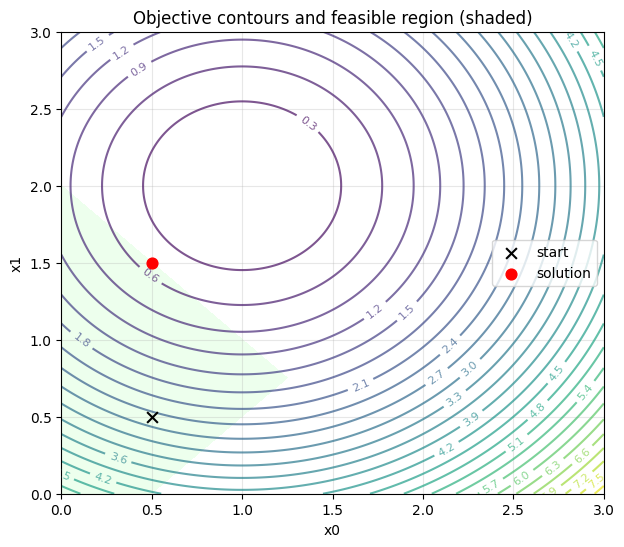

In [12]:
opt = Optimizer(
    lambda x: (x[0] - 1.0)**2 + (x[1] - 2.0)**2, 
    x0, 
    bounds=[(0.0, 3.0), (0.0, 3.0)], 
    ineq_constraints=[
    {'fun': lambda x: 2.0 - (x[0] + x[1])},
    {'fun': lambda x: 0.5 - x[0] + x[1]}
    ],
    # eq_constraints=[
    # {'fun': lambda x: x[0] - 1}
    # ]
    )
result = opt.optimize()
opt.print_result()
opt.visualize()